# Normalization

**Import**

In [1]:
# from second tutorial notebook (Part02)
import scanpy as sc
import pandas as pd
import scvelo as scv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import ipywidgets as widgets

# others
import re
import os

# first tutorial
import bbknn
import diffxpy.api as dxpy
import plotly.express as px

# Meritxell's
import anndata2ri

In [2]:
# Meritxell's normalization
# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
anndata2ri.activate()

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

sc.settings.verbosity = 3
#sc.logging.print_versions()

**Read anndata matrix**

In [4]:
path_out = f'/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/data/mapping/BON/adata/'

adata_out_mm = f'{path_out}/preproc_1_starsolo_multimap_bon.h5ad'

In [6]:
# open saved data
adata = sc.read(adata_out_mm)

In [8]:
adata

AnnData object with n_obs × n_vars = 7329 × 25535
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells'
    layers: 'raw_counts', 'spliced', 'unspliced'

The highly spliced cells cluster together so I remove cells with over 50 % 

In [9]:
adata=adata[adata.obs['prop_spl']<0.5].copy()

In [11]:
adata

AnnData object with n_obs × n_vars = 5043 × 25535
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells'
    layers: 'raw_counts', 'spliced', 'unspliced'

In [15]:
cd '/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/tutorial/'

/faststorage/project/testis_singlecell/Workspaces/adahl/birc-project-akd/tutorial


In [16]:
%run Scripts/pythonScripts.py

In [17]:
#from /home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/tutorial/Scripts/pythonScripts import dependentFeatures

#PCA on unnormalized data
sc.preprocessing.pca(adata, svd_solver='arpack', random_state=12345)
#Calculating correlations
dependentFeatures(adata=adata, obs_subset=['total_counts','percent_mito']) # plots the PC with the highest R2 to total counts and percent mito, respectively


computing PCA
    on highly variable genes
    with n_comps=50


KeyboardInterrupt: 

The third biggest variation in the data at this point is explained by total UMI count. Normalizing should remove this bias.

In [16]:
rawMatrix = adata.X.todense().T
cells = adata.obs_names
genes = adata.var_names
dataset = np.array(adata.obs["DATASET"])

In [17]:
rawMatrix.shape

(25535, 5043)

In [18]:
%%R -i rawMatrix -i cells -i genes -i dataset -o norm_sct -o umi_corr -o genes_var

library(Seurat)
colnames(rawMatrix) <- cells
rownames(rawMatrix) <- genes
meta <- data.frame(DATASET = dataset)  # add batch as metadata
print(dim(rawMatrix))
seurat_df <- CreateSeuratObject(rawMatrix)
seurat_df <- AddMetaData(seurat_df, meta$DATASET, col.name = "DATASET")
# scTransform
seurat_df <- SCTransform(seurat_df, verbose = TRUE, variable.features.n = length(genes), vars.to.regress = c("DATASET"), return.only.var.genes=FALSE) # normalize data with Negative binomial regression
# Get matrix of residuals
norm_sct <- GetAssayData(seurat_df,assay="SCT",slot="scale.data") # assign normalized and scaled data (not 0 mean scaling)
umi_corr <- GetAssayData(seurat_df,assay="SCT",slot="counts")
genes_var <- rownames(seurat_df$SCT)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: Attaching SeuratObject



[1] 25535  5043


R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 25535 by 5043

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 5000 cells



  |======================================================================| 100%


R[write to console]: Found 44 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 25535 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 25535 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.673714 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Regressing out DATASET

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                        

In [19]:
norm_sct.shape

(25535, 5043)

In [20]:
# remove objects from R workspace that I will no longer need
# %%R
# rm(list = ls())

In [21]:
adata.var_names = ["-".join(x.split("_")) for x in adata.var_names] # change _ in gene names to - so it works in R code
adata = adata[:,np.array(genes_var)].copy() # only use genes ...
# creating SCT layers in anndata object
adata.layers["norm_sct"] = norm_sct.T
adata.layers["umi_corr"] = umi_corr.T

In [22]:
adata.layers["norm_sct"]

array([[-0.38624061, -0.0533433 , -0.11852944, ..., -0.17378488,
        -0.08765947, -0.32689791],
       [ 3.37791163, -0.04600964, -0.10156935, ..., -0.13910251,
        -0.074139  , -0.28549243],
       [-0.52358889, -0.07991128, -0.18076913, ..., -0.30137505,
        -0.13673458, -0.47723768],
       ...,
       [-0.22962205, -0.07757154, -0.16150276, ..., -0.38675177,
        -0.14854633, -0.40094363],
       [-0.369877  , -0.10472299, -0.22516694, ..., -0.51716447,
        -0.19869875, -0.55431673],
       [-0.31920056, -0.09486361, -0.20196574, ..., -0.46983733,
        -0.18049131, -0.49915436]])

In [23]:
adata.X = adata.layers['norm_sct'].copy() # normalized and scaled matrix as default

In [24]:
sc.pp.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:28)


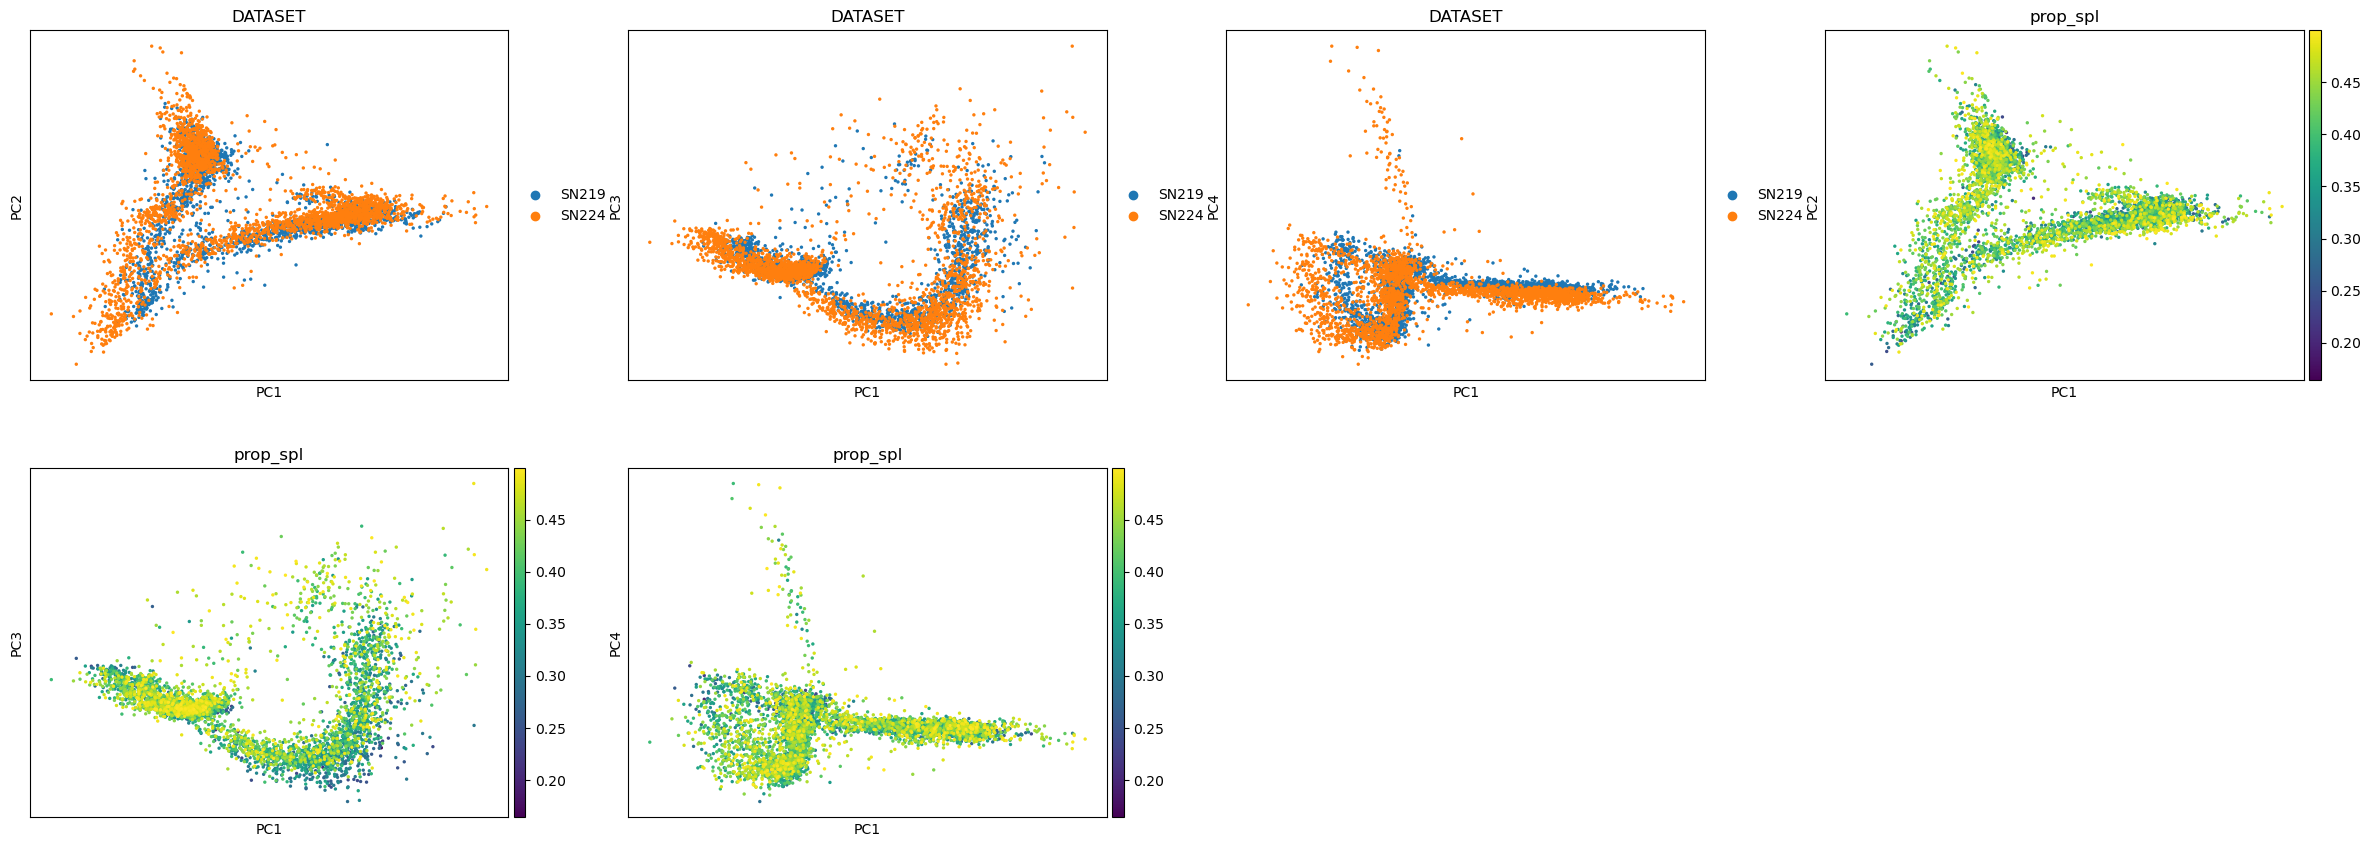

In [25]:
sc.pl.pca(adata, color=['DATASET','prop_spl'], components=['1,2','1,3','1,4'])

In [26]:
# most variable genes, True or False
sc.pp.highly_variable_genes(adata, n_top_genes=10000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [27]:
adata.to_df()

LOC100996442  LOC729737  LOC112268260  LOC100132287  \
SN219_AAACCTGAGAAAGTGG     -0.386241  -0.053343     -0.118529     -0.037523   
SN219_AAACCTGAGGCGCTCT      3.377912  -0.046010     -0.101569     -0.030880   
SN219_AAACCTGAGTCGCCGT     -0.523589  -0.079911     -0.180769     -0.061691   
SN219_AAACCTGCAGCGTTCG     -0.381603  -0.052443     -0.116440     -0.036707   
SN219_AAACCTGGTAAGAGAG      2.668973  -0.055536     -0.123626     -0.039512   
...                              ...        ...           ...           ...   
SN224_TTTGTCAAGGGATCTG     -0.273766  -0.086095     -0.181394     -0.073653   
SN224_TTTGTCAAGTGAACGC     -0.383279  -0.107356     -0.231367     -0.093025   
SN224_TTTGTCACAGTAGAGC     -0.229622  -0.077572     -0.161503     -0.065912   
SN224_TTTGTCACATCCTTGC     -0.369877  -0.104723     -0.225167     -0.090621   
SN224_TTTGTCATCCGCAGTG     -0.319201  -0.094864     -0.201966     -0.081632   

                        LOC105378947    OR4F16  LOC100288069  LINC01409  \
SN219_AAACCTGAGAAAGTGG     -0.037690 -0.106670     -0.126046  -0.186836   
SN219_AAACCTGAGGCGCTCT     -0.032441 -0.097833     -0.112689  -0.163419   
SN219_AAACCTGAGTCGCCGT     -0.056681 -0.138496     -0.174498  -0.274023   
SN219_AAACCTGCAGCGTTCG     -0.037046 -0.105586     -0.124405  -0.183941   
SN219_AAACCTGGTAAGAGAG     -0.039259 -0.109307     -0.130043  -0.193910   
...                              ...       ...           ...        ...   
SN224_TTTGTCAAGGGATCTG     -0.045638 -0.087137     -0.128389  -0.236086   
SN224_TTTGTCAAGTGAACGC     -0.060828 -0.112545     -0.167151  -0.306400   
SN224_TTTGTCACAGTAGAGC     -0.039542 -0.076902     12.977939  -0.208357   
SN224_TTTGTCACATCCTTGC     -0.058948 -0.109407     -0.162356  -0.297644   
SN224_TTTGTCATCCGCAGTG     -0.051905 -0.097636     -0.144385  -0.264946   

                        LINC00115  LINC01128  ...       ND2      COX1  \
SN219_AAACCTGAGAAAGTGG   2.125137  -0.373055  ... -0.134934 -0.859680   
SN219_AAACCTGAGGCGCTCT  -0.176008  -0.330339  ... -0.110018 -0.791249   
SN219_AAACCTGAGTCGCCGT  -0.301013  -0.527920  ... -0.227817  1.783679   
SN219_AAACCTGCAGCGTTCG  -0.199171  -0.367789  ... -0.131852 -0.851296   
SN219_AAACCTGGTAAGAGAG  -0.210433  -0.385895  ... -0.142464  0.745629   
...                           ...        ...  ...       ...       ...   
SN224_TTTGTCAAGGGATCTG  -0.216444  -0.330638  ... -0.305914 -0.537801   
SN224_TTTGTCAAGTGAACGC  -0.295942  -0.453517  ... -0.380839  0.152757   
SN224_TTTGTCACAGTAGAGC  -0.185100  -0.280642  ... -0.276382  1.187675   
SN224_TTTGTCACATCCTTGC  -0.286048  -0.438592  ...  2.735838  0.220162   
SN224_TTTGTCATCCGCAGTG  -0.249080  -0.381854  ... -0.336664 -0.615479   

                            COX2      ATP6      COX3       ND3      ND4L  \
SN219_AAACCTGAGAAAGTGG -0.233664  2.880267 -0.673173 -0.187878 -0.108003   
SN219_AAACCTGAGGCGCTCT -0.202840 -0.186319 -0.601011 -0.172444 -0.099554   
SN219_AAACCTGAGTCGCCGT -0.348068 -0.365987 -0.917885 -0.244253 -0.138455   
SN219_AAACCTGCAGCGTTCG -0.229853 -0.220219 -0.664352 -0.185979 -0.106967   
SN219_AAACCTGGTAAGAGAG -0.242975 -0.236624 -0.694584 -0.192508 -0.110526   
...                          ...       ...       ...       ...       ...   
SN224_TTTGTCAAGGGATCTG -0.317883 -0.464694 -0.772132  6.033520 -0.060665   
SN224_TTTGTCAAGTGAACGC -0.409877 -0.576979 -0.958732 -0.155340 -0.084983   
SN224_TTTGTCACAGTAGAGC -0.281405 -0.419326 -0.690233 -0.092095 -0.050875   
SN224_TTTGTCACATCCTTGC  2.698648 -0.563263 -0.097838 -0.149739 -0.081979   
SN224_TTTGTCATCCGCAGTG -0.355757 -0.511332 -0.852756 -0.128765 -0.070711   

                             ND4       ND5      CYTB  
SN219_AAACCTGAGAAAGTGG -0.173785 -0.087659 -0.326898  
SN219_AAACCTGAGGCGCTCT -0.139103 -0.074139 -0.285492  
SN219_AAACCTGAGTCGCCGT -0.301375 -0.136735 -0.477238  
SN219_AAACCTGCAGCGTTCG -0.169502 -0.085998 -0.321793  
SN219_AAACCTGGTAAGAGAG -0.184241 -0.091706 -0.339348  
...                          ...       ...       ...  

In [28]:
adata.var

gene_ids    feature_types chromosome  n_cells  \
LOC100996442  LOC100996442  Gene Expression          1     1543   
LOC729737        LOC729737  Gene Expression          1      277   
LOC112268260  LOC112268260  Gene Expression          1      426   
LOC100132287  LOC100132287  Gene Expression          1      193   
LOC105378947  LOC105378947  Gene Expression          1       55   
...                    ...              ...        ...      ...   
ND3                    ND3  Gene Expression         MT      309   
ND4L                  ND4L  Gene Expression         MT      132   
ND4                    ND4  Gene Expression         MT     1159   
ND5                    ND5  Gene Expression         MT      285   
CYTB                  CYTB  Gene Expression         MT     1405   

              highly_variable     means  dispersions  dispersions_norm  
LOC100996442            False  3.331730    10.441991         -0.174233  
LOC729737                True  6.305480    12.902386          1.242308  
LOC112268260             True  6.079741    12.774402          0.768671  
LOC100132287             True  4.500948    12.963536          0.999819  
LOC105378947             True  5.624970    12.907269          1.100221  
...                       ...       ...          ...               ...  
ND3                      True  5.915785    12.765218          0.642654  
ND4L                     True  6.102148    12.727631          0.595583  
ND4                      True  6.963824    12.750531          0.463437  
ND5                      True  5.458724    12.702869          0.511602  
CYTB                    False  7.328714    12.849623          0.268374  

[25535 rows x 8 columns]

In [29]:
adata.layers

Layers with keys: raw_counts, spliced, unspliced, norm_sct, umi_corr

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:13)


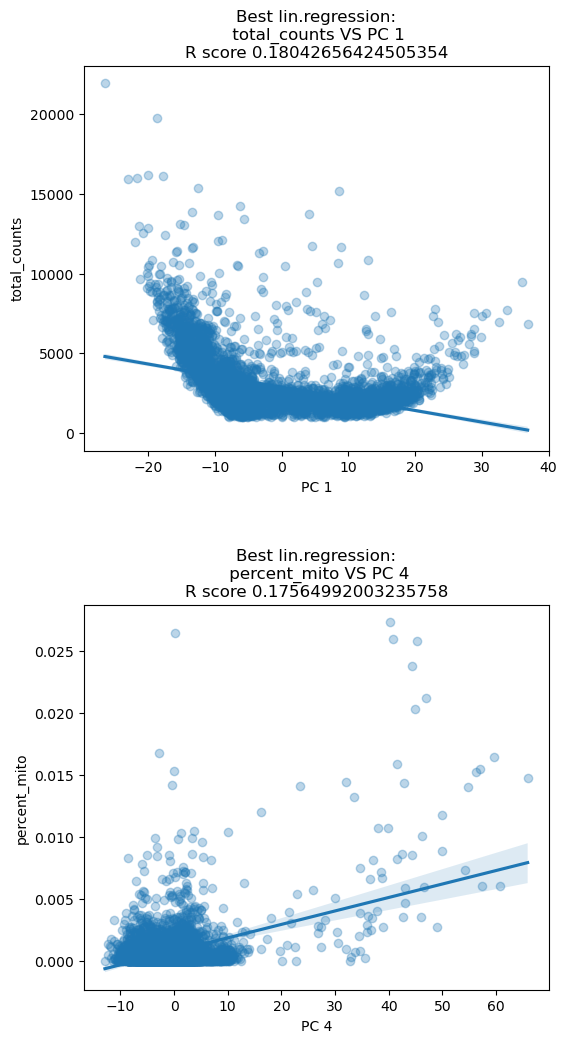

In [30]:
#PCA on normalized data
sc.preprocessing.pca(adata, svd_solver='arpack', random_state=12345)
#Calculating correlations
dependentFeatures(adata=adata, obs_subset=['total_counts','percent_mito'])

Now the correlation isn't strong.

Luckily the samples overlap, so they can be analyzed combined

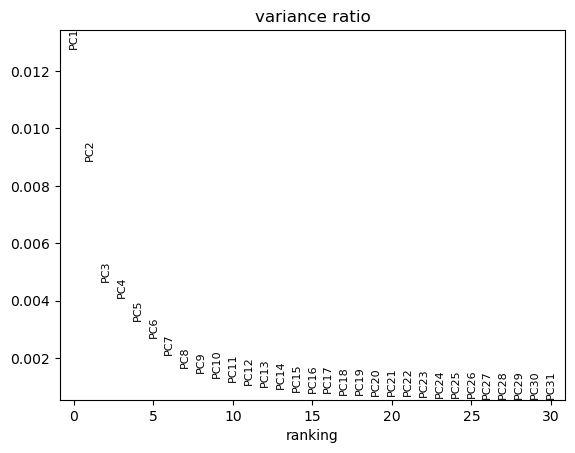

In [31]:
sc.plotting.pca_variance_ratio(adata) # small variance means it probably models noice in the data

Keep the PCs with the most variance, e.g. up to PC10

In [32]:
#sc.pp.neighbors(adata, n_pcs=15, random_state=12345) # use only for data with one single sample
bbknn.bbknn(adata, batch_key='DATASET', n_pcs=10)

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [33]:
sc.tools.umap(adata, random_state=54321)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


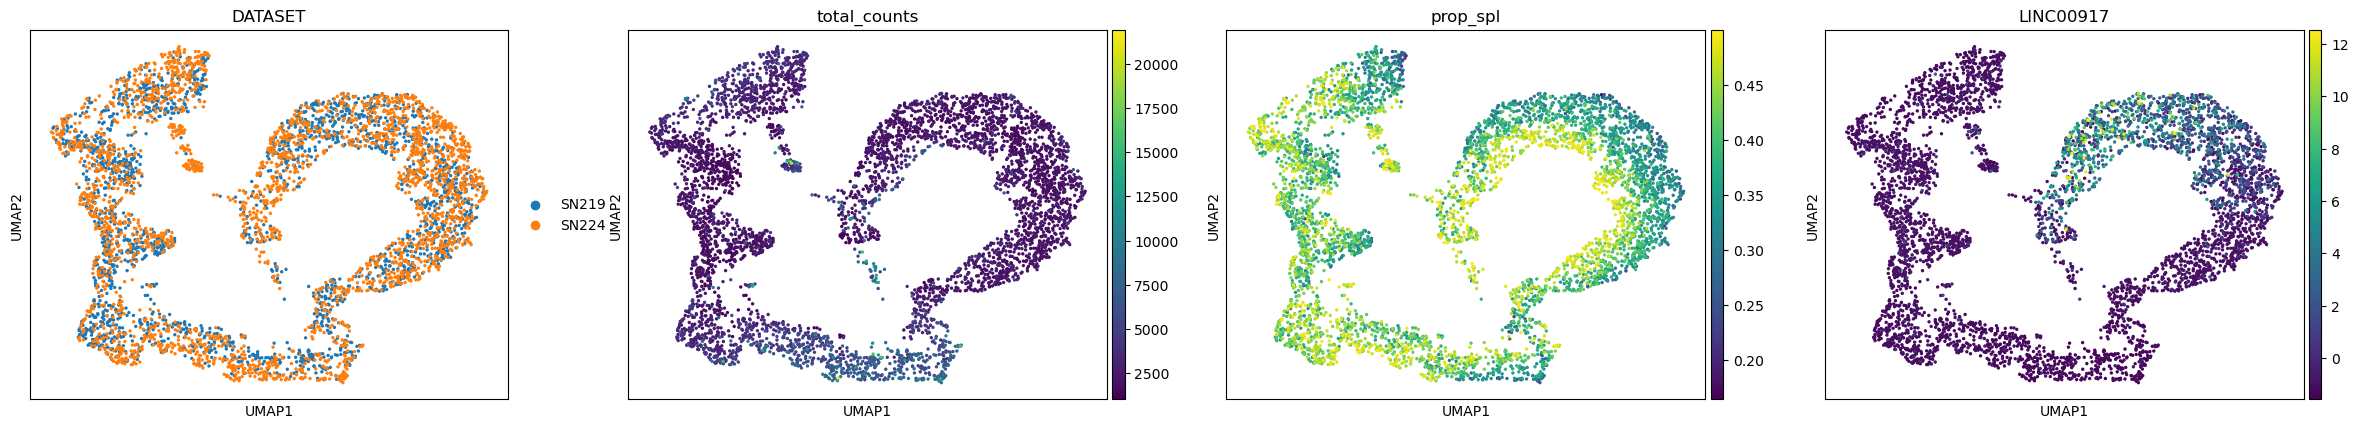

In [34]:
sc.plotting.umap(adata, color=['DATASET','total_counts','prop_spl','LINC00917'])

In [35]:
adata

AnnData object with n_obs × n_vars = 5043 × 25535
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'DATASET_colors', 'hvg', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'spliced', 'unspliced', 'norm_sct', 'umi_corr'
    obsp: 'distances', 'connectivities'

In [36]:
adata.uns['pca']

{'params': {'zero_center': True, 'use_highly_variable': True},
 'variance': array([119.37138189,  82.98727617,  43.48784434,  38.47949517,
         30.99953979,  25.39977769,  19.96831733,  15.4750494 ,
         13.82708839,  12.27302252,  11.05239333,   9.99488437,
          9.29993661,   8.84939513,   7.90496607,   7.60186012,
          7.29657329,   6.92243335,   6.69733101,   6.57849214,
          6.43792826,   6.36139418,   6.12398999,   5.88371201,
          5.71432624,   5.67527426,   5.62316167,   5.59724213,
          5.54662156,   5.51895323,   5.47507133,   5.45241779,
          5.42822287,   5.4150085 ,   5.39891229,   5.39456325,
          5.39303976,   5.37276846,   5.35754299,   5.35514036,
          5.33261657,   5.32758945,   5.31682024,   5.3059887 ,
          5.28843434,   5.28041403,   5.26578102,   5.26413883,
          5.2524446 ,   5.24594796]),
 'variance_ratio': array([0.01278062, 0.00888512, 0.00465607, 0.00411985, 0.003319  ,
        0.00271945, 0.00213793, 0

In [37]:
# higher marker scores when only a few is considered and therefore more visible clusters
markers = dict() #make an empty dictionary
### SPERMATOCYTOGENESIS
markers['SpermatogoniaA'] = ['ID4','HMGA1']
markers['SpermatogoniaB'] = ['MKI67','DMRT1','STRA8'] 
markers['SpermatocytesI'] = ['MEIOB','PRSS50','SYCP1','TEX101']
markers['SpermatocytesII'] = ['PIWIL1','ACRV1','SPATA16','CLGN']
### SPERMIOGENESIS
markers['Round.Spt'] = ['SPATA9','SPAM1'] #Round spermatids
markers['Elong.Spt'] = ['PRM1','PRM2'] #Elongated spermatids
### SOMATIC CELLS
markers['Sertoli'] = ['CTSL', 'VIM']
markers['Macroph'] = ['CD163','TYROBP']
markers['Leydig'] = ['CFD']
markers['Endothelial'] = ['CD34']

In [43]:
# Markers from the group google doc added
markers = dict() #make an empty dictionary
### SPERMATOCYTOGENESIS
markers['SpermatogoniaA'] = ['ID4','HMGA1','PIWIL4','UTF1','SLC22A2','FGFR3']
markers['SpermatogoniaB'] = ['MKI67','DMRT1','STRA8','ANP32B','SDF2L1','DMRT1','NANOS3'] # add markers for both?
markers['SpermatocytesI'] = ['MEIOB','PRSS50','SYCP1','TEX101','SPAG6','FTHL17','ART3','KCTD19','ASRGL1','LDHAL6B','LYAR','ZPBP2','ADAM2','CLGN','DDX25'] # general 'MYBL1','SYCP3','HORMAD1','SYNGR4', missing a few pachytene markers
markers['SpermatocytesII'] = ['PIWIL1','ACRV1','SPATA16','CLGN','UBE2T']
### SPERMIOGENESIS
markers['Round.Spt'] = ['SPATA9','SPAM1','DNAJB13','EFHB','LYZL6','PSD3','SLC16A7','TBC1D21','TMEM144'] # missing a few markers
markers['Elong.Spt'] = ['PRM1','PRM2','AGPAT2','AKAP1','BAG1','CST8','DNAJB7','DNAJB8','FNDC8','LELP1','RANGAP1','SPATA3','TSSK6','TXNDC2','TNP1','TP53TG5']
### SOMATIC CELLS
markers['Sertoli'] = ['CTSL','VIM','ACSL4','WT1','GAS6','BCAR1','DMRT1'] 
markers['Macroph'] = ['CD163','TYROBP']
markers['Leydig'] = ['ACTA2','CFD','IGF1','IGFBP5','CYP19A1','CYP17A1','INSL3']
markers['Endothelial'] = ['CD34']

In [40]:
# markers in article
markers = dict() #make an empty dictionary
### SPERMATOCYTOGENESIS
markers['Undif. SG'] = ['GFRA1','PIWIL4','STRA8'] #STRA8 for both
markers['Dif. SG'] = ['DMRT1','STRA8'] 
markers['Lept. SC'] = ['SYCE1','SYCP2','TANK'] #SYCP2, TANK, AURKA for all three
markers['Zyg. SC'] = ['SYCP1'] # very distinct
markers['Pach.Dipl. SC'] = ['PIWIL1','SYCP2','TANK']
### SPERMIOGENESIS
markers['Early round SD'] = ['LRRIQ1'] #Round spermatids
markers['Late round SD'] = ['ACRV1','SPACA1'] #Round spermatids
markers['Elong SD'] = ['SPATA3','NRBP1','PRM1','GABBR2'] #Elongated spermatids
### SOMATIC CELLS
markers['Sertoli'] = ['CLU'] # very distinct
markers['Macroph'] = ['APOE','CD74']
markers['Leydig'] = ['STAR','CYP11A1']
markers['Endothelial'] = ['CD34'] #'TM4SF1' not expressed

In [49]:
# markers in article not separated in SC phases
markers = dict() #make an empty dictionary
### SPERMATOCYTOGENESIS
markers['Undif. SG'] = ['GFRA1','PIWIL4','STRA8'] #STRA8 for both
markers['Dif. SG'] = ['DMRT1','STRA8'] 
markers['SC'] = ['SYCP2','TANK','AURKA'] #SYCP2, TANK, AURKA for all three
markers['Zyg. SC'] = ['SYCP1'] # very distinct
### SPERMIOGENESIS
markers['Early round SD'] = ['LRRIQ1'] #Round spermatids, Distinct
markers['Late round SD'] = ['ACRV1','SPACA1'] #Round spermatids, Distinct
markers['Elong SD'] = ['SPATA3','NRBP1','PRM1','GABBR2'] #Elongated spermatids
### SOMATIC CELLS
markers['Sertoli'] = ['CLU'] # very distinct
markers['Macroph'] = ['APOE','CD74']
markers['Leydig'] = ['STAR','CYP11A1']
markers['Endothelial'] = ['CD34'] #'TM4SF1' not expressed

In [9]:
# markers in article and course mixed
markers = dict() #make an empty dictionary
#markers['SpermatogoniaB'] = ['MKI67','DMRT1','STRA8'] 
### SPERMATOCYTOGENESIS
markers['Undif. SG'] = ['ID4','HMGA1'] # course
markers['Dif. SG'] = ['MKI67','DMRT1','STRA8'] # course
markers['SC.I'] = ['MEIOB','PRSS50','SYCP1','TEX101'] # course
markers['SC.II'] = ['PIWIL1','ACRV1','SPATA16','CLGN'] # course
### SPERMIOGENESIS
markers['Early round SD'] = ['LRRIQ1'] #Round spermatids, Distinct #better than tutorial
markers['Late round SD'] = ['ACRV1','SPACA1'] #Round spermatids, Distinct #better than tutorial
markers['Elong SD'] = ['SPATA3','NRBP1','PRM1','GABBR2'] #Elongated spermatids #better than tutorial
### SOMATIC CELLS
markers['Sertoli'] = ['CLU'] # very distinct #better than tutorial
markers['Macroph'] = ['APOE','CD74']
markers['Leydig'] = ['STAR','CYP11A1']
markers['Endothelial'] = ['CD34'] #'TM4SF1' not expressed

In [18]:
markers_scores, adata = marker_score(markers, adata)

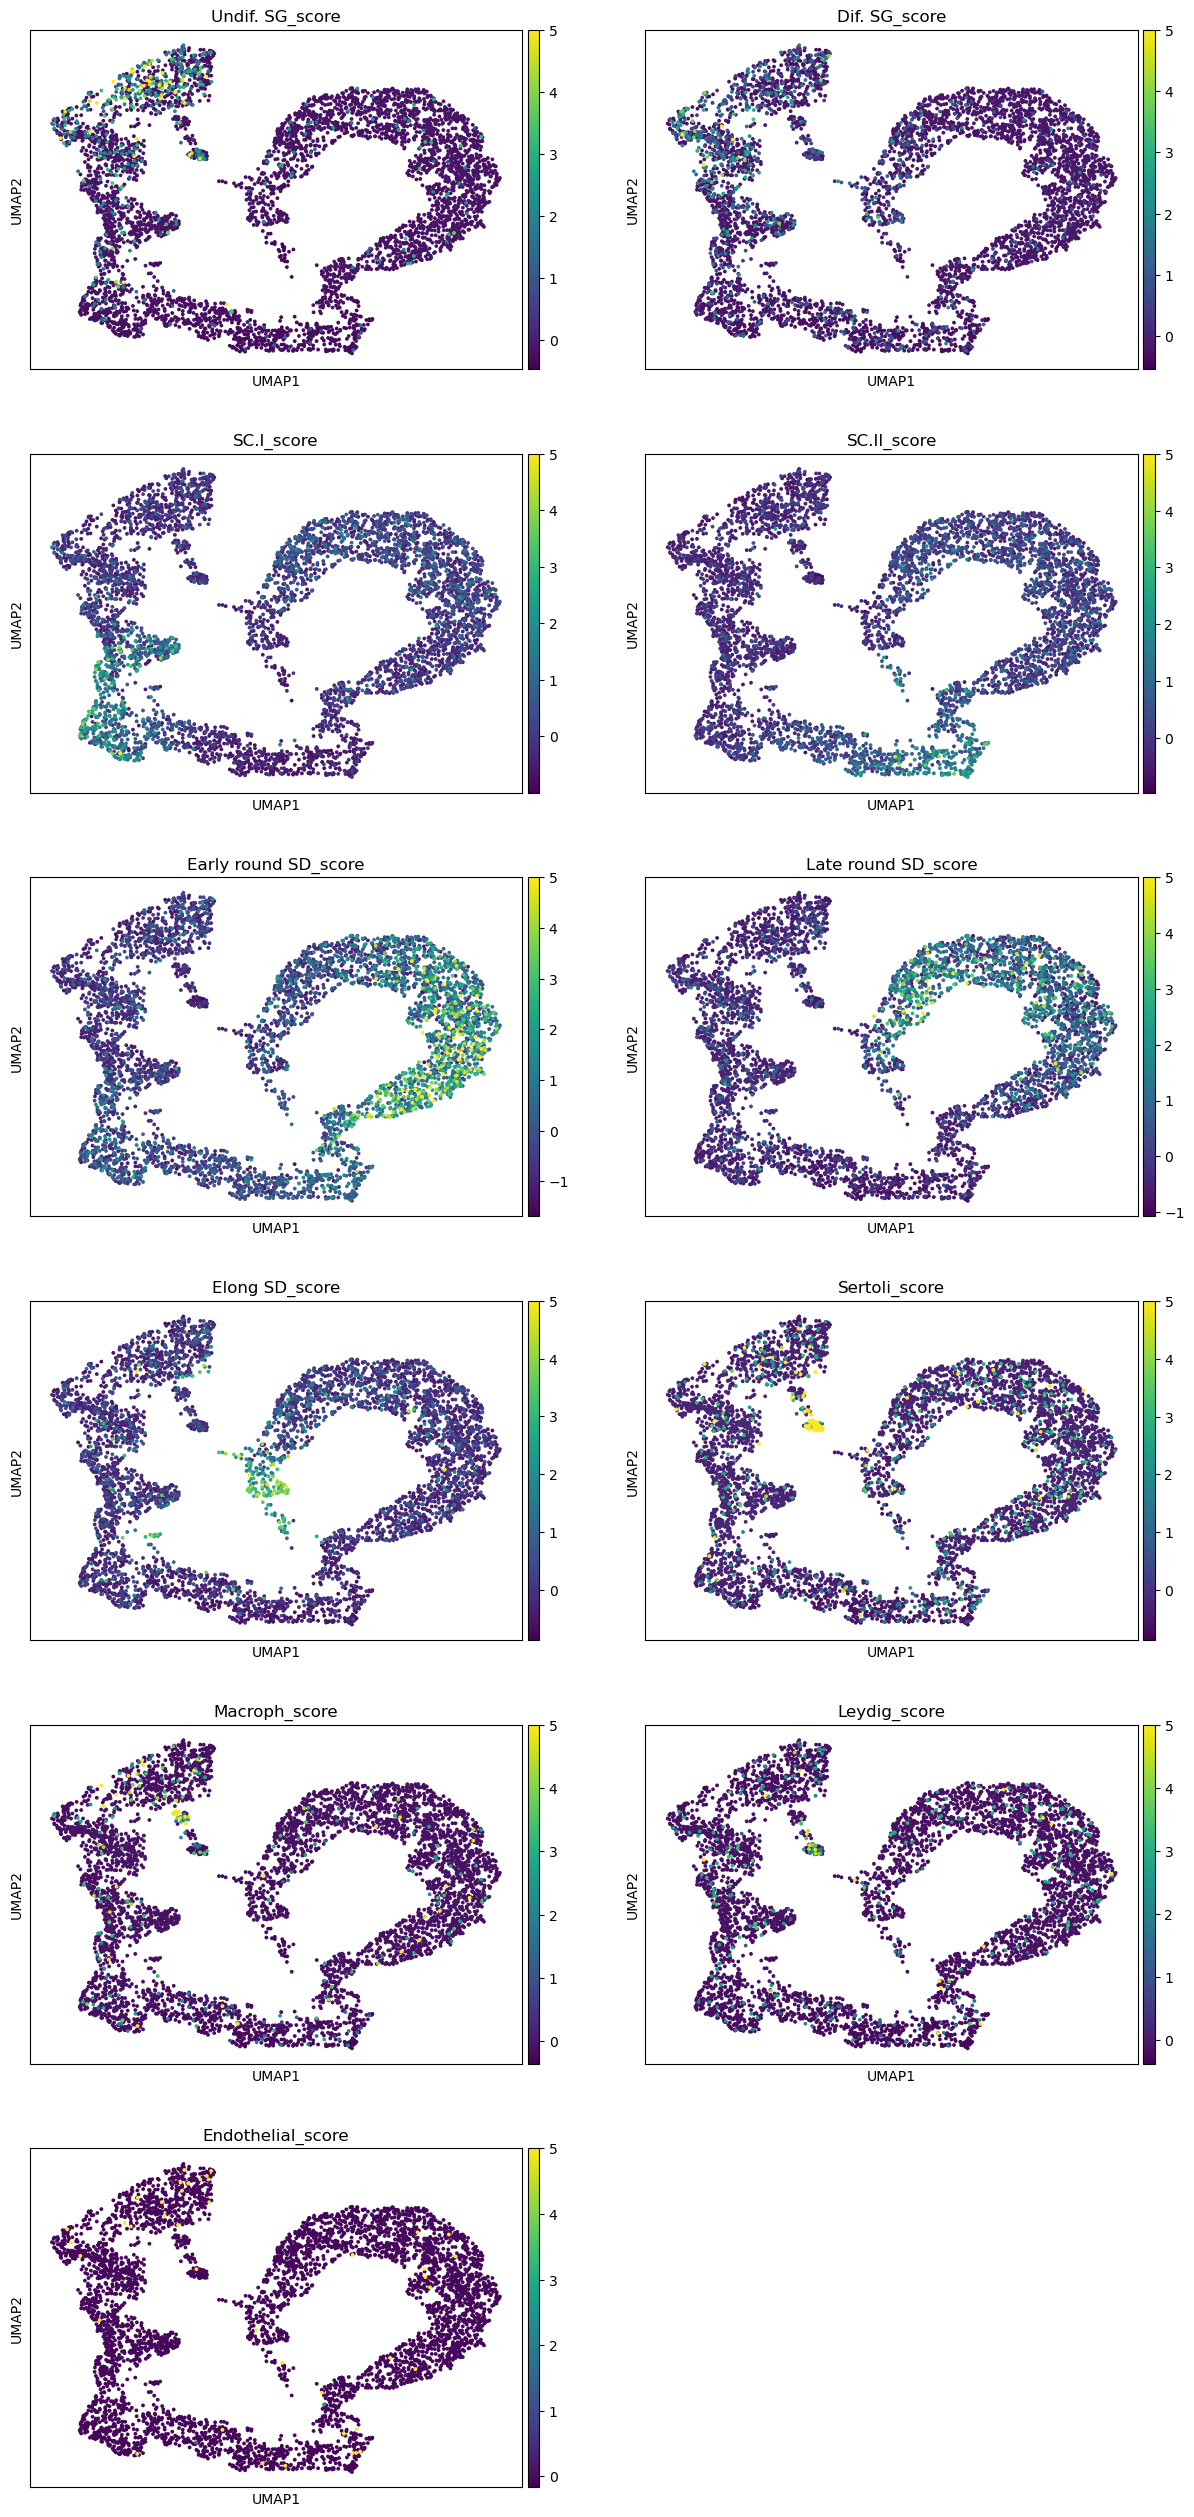

In [19]:
sc.plotting.umap(adata, color=markers_scores, components=['1,2'], ncols=2, vmax=5, s=30)

In [89]:
#leiden clustering at various resolutions
sc.tools.leiden(adata, resolution=0.3, random_state=12345, key_added='leiden_R.3')
sc.tools.leiden(adata, resolution=0.2, random_state=12345, key_added='leiden_R.2')
sc.tools.leiden(adata, resolution=0.1, random_state=12345, key_added='leiden_R.1')

running Leiden clustering
    finished: found 12 clusters and added
    'leiden_R.3', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_R.2', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_R.1', the cluster labels (adata.obs, categorical) (0:00:00)


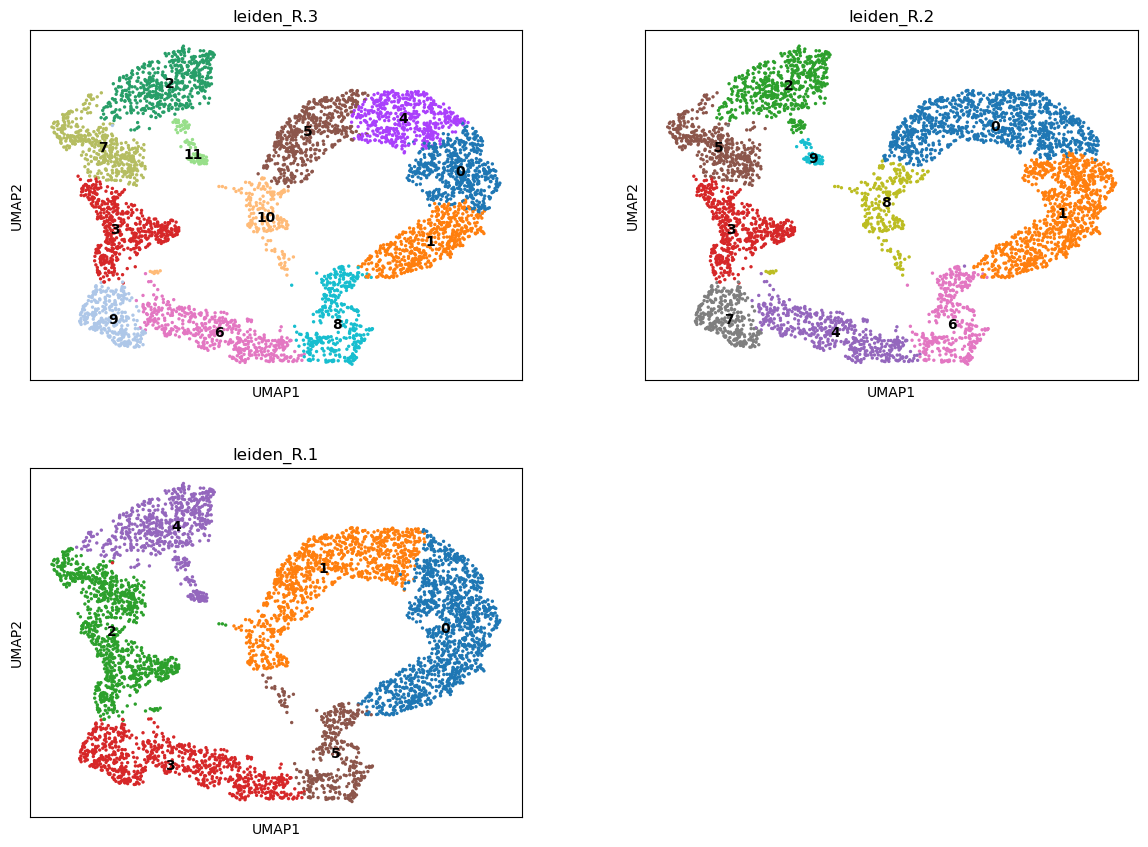

In [90]:
sc.plotting.umap(adata, color=['leiden_R.3','leiden_R.2','leiden_R.1'], legend_loc='on data', ncols=2)

In [7]:
adata.layers

Layers with keys: norm_sct, raw_counts, spliced, umi_corr, unspliced

In [20]:
adata

AnnData object with n_obs × n_vars = 5043 × 25535
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets', 'SpermatogoniaA_score', 'SpermatogoniaB_score', 'SpermatocytesI_score', 'SpermatocytesII_score', 'Round.Spt_score', 'Elong.Spt_score', 'Sertoli_score', 'Macroph_score', 'Leydig_score', 'Endothelial_score', 'Undif. SG_score', 'Dif. SG_score', 'Lept. SC_score', 'Zyg. SC_score', 'Pach.Dipl. SC_score', 'Early round SD_score', 'Late round SD_score', 'Elong SD_score', 'SC_score', 'SC.I_score', 'SC.II_score', 'leiden_R.3', 'leiden_R.2', 'leiden_R.1'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DATASET_colors', 'hvg', 'leiden', 'leiden_R.1_colors', 'leiden_R.2_colors', 'leiden_R.3_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'norm_sct', 'r

Comparing the Leiden clusters to the clusters represented by cell markers resolution 0,3 match the best

In [45]:
sc.tl.rank_genes_groups(adata, groupby='leiden_R.3', n_genes=50, key_added='DE_leiden') # diff.expressed genes in each cluster (t-test)

ranking genes
    finished: added to `.uns['DE_leiden']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


In [46]:
adata.uns['DE_leiden']

{'params': {'groupby': 'leiden_R.3',
  'reference': 'rest',
  'method': 't-test',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('SPAG16', 'LOC105372004', 'amplicon-chrX-GAGE10/1/2A/13/12B/12C/12D/12E/12F/12G/12H/12J', 'ZCWPW1', 'LOC440896', 'LOC440896', 'LINC01507', 'amplicon-chrX-GAGE10/1/2A/13/12B/12C/12D/12E/12F/12G/12H/12J', 'CRB1', 'LINC01794', 'CCDC168', 'ZBTB20'),
            ('NLRP1', 'LRRIQ1', 'PARD3', 'SMC1B', 'LINC00917', 'LINC00917', 'RFX4', 'RPS2', 'C1QTNF3', 'MALAT1', 'LINC01000', 'CARMIL1'),
            ('GOLGA6L2', 'NPIPB15', 'amplicon-chrX-PAGE2/2B/5', 'amplicon-chrX-VCX/2/3A/3B', 'TEX51', 'LRMDA', 'ANKRD7', 'LOC100507336', 'LINC02475', 'LOC105373554', 'PRM1', 'ERBB4'),
            ('TEX51', 'LOC101929894', 'HMGB1', 'MALAT1', 'PLCZ1', 'CCSER1', 'LOC105379102', 'amplicon-chrX-RHOXF2/B', 'CCDC38', 'SPDYE14', 'TNP1', 'COL1A2'),
            ('LOC105372004', 'PACRG', 'NRG3', 'AUTS2', 'CLDND2', 'EML2-AS1', 'DPY19L2', 'JMJD

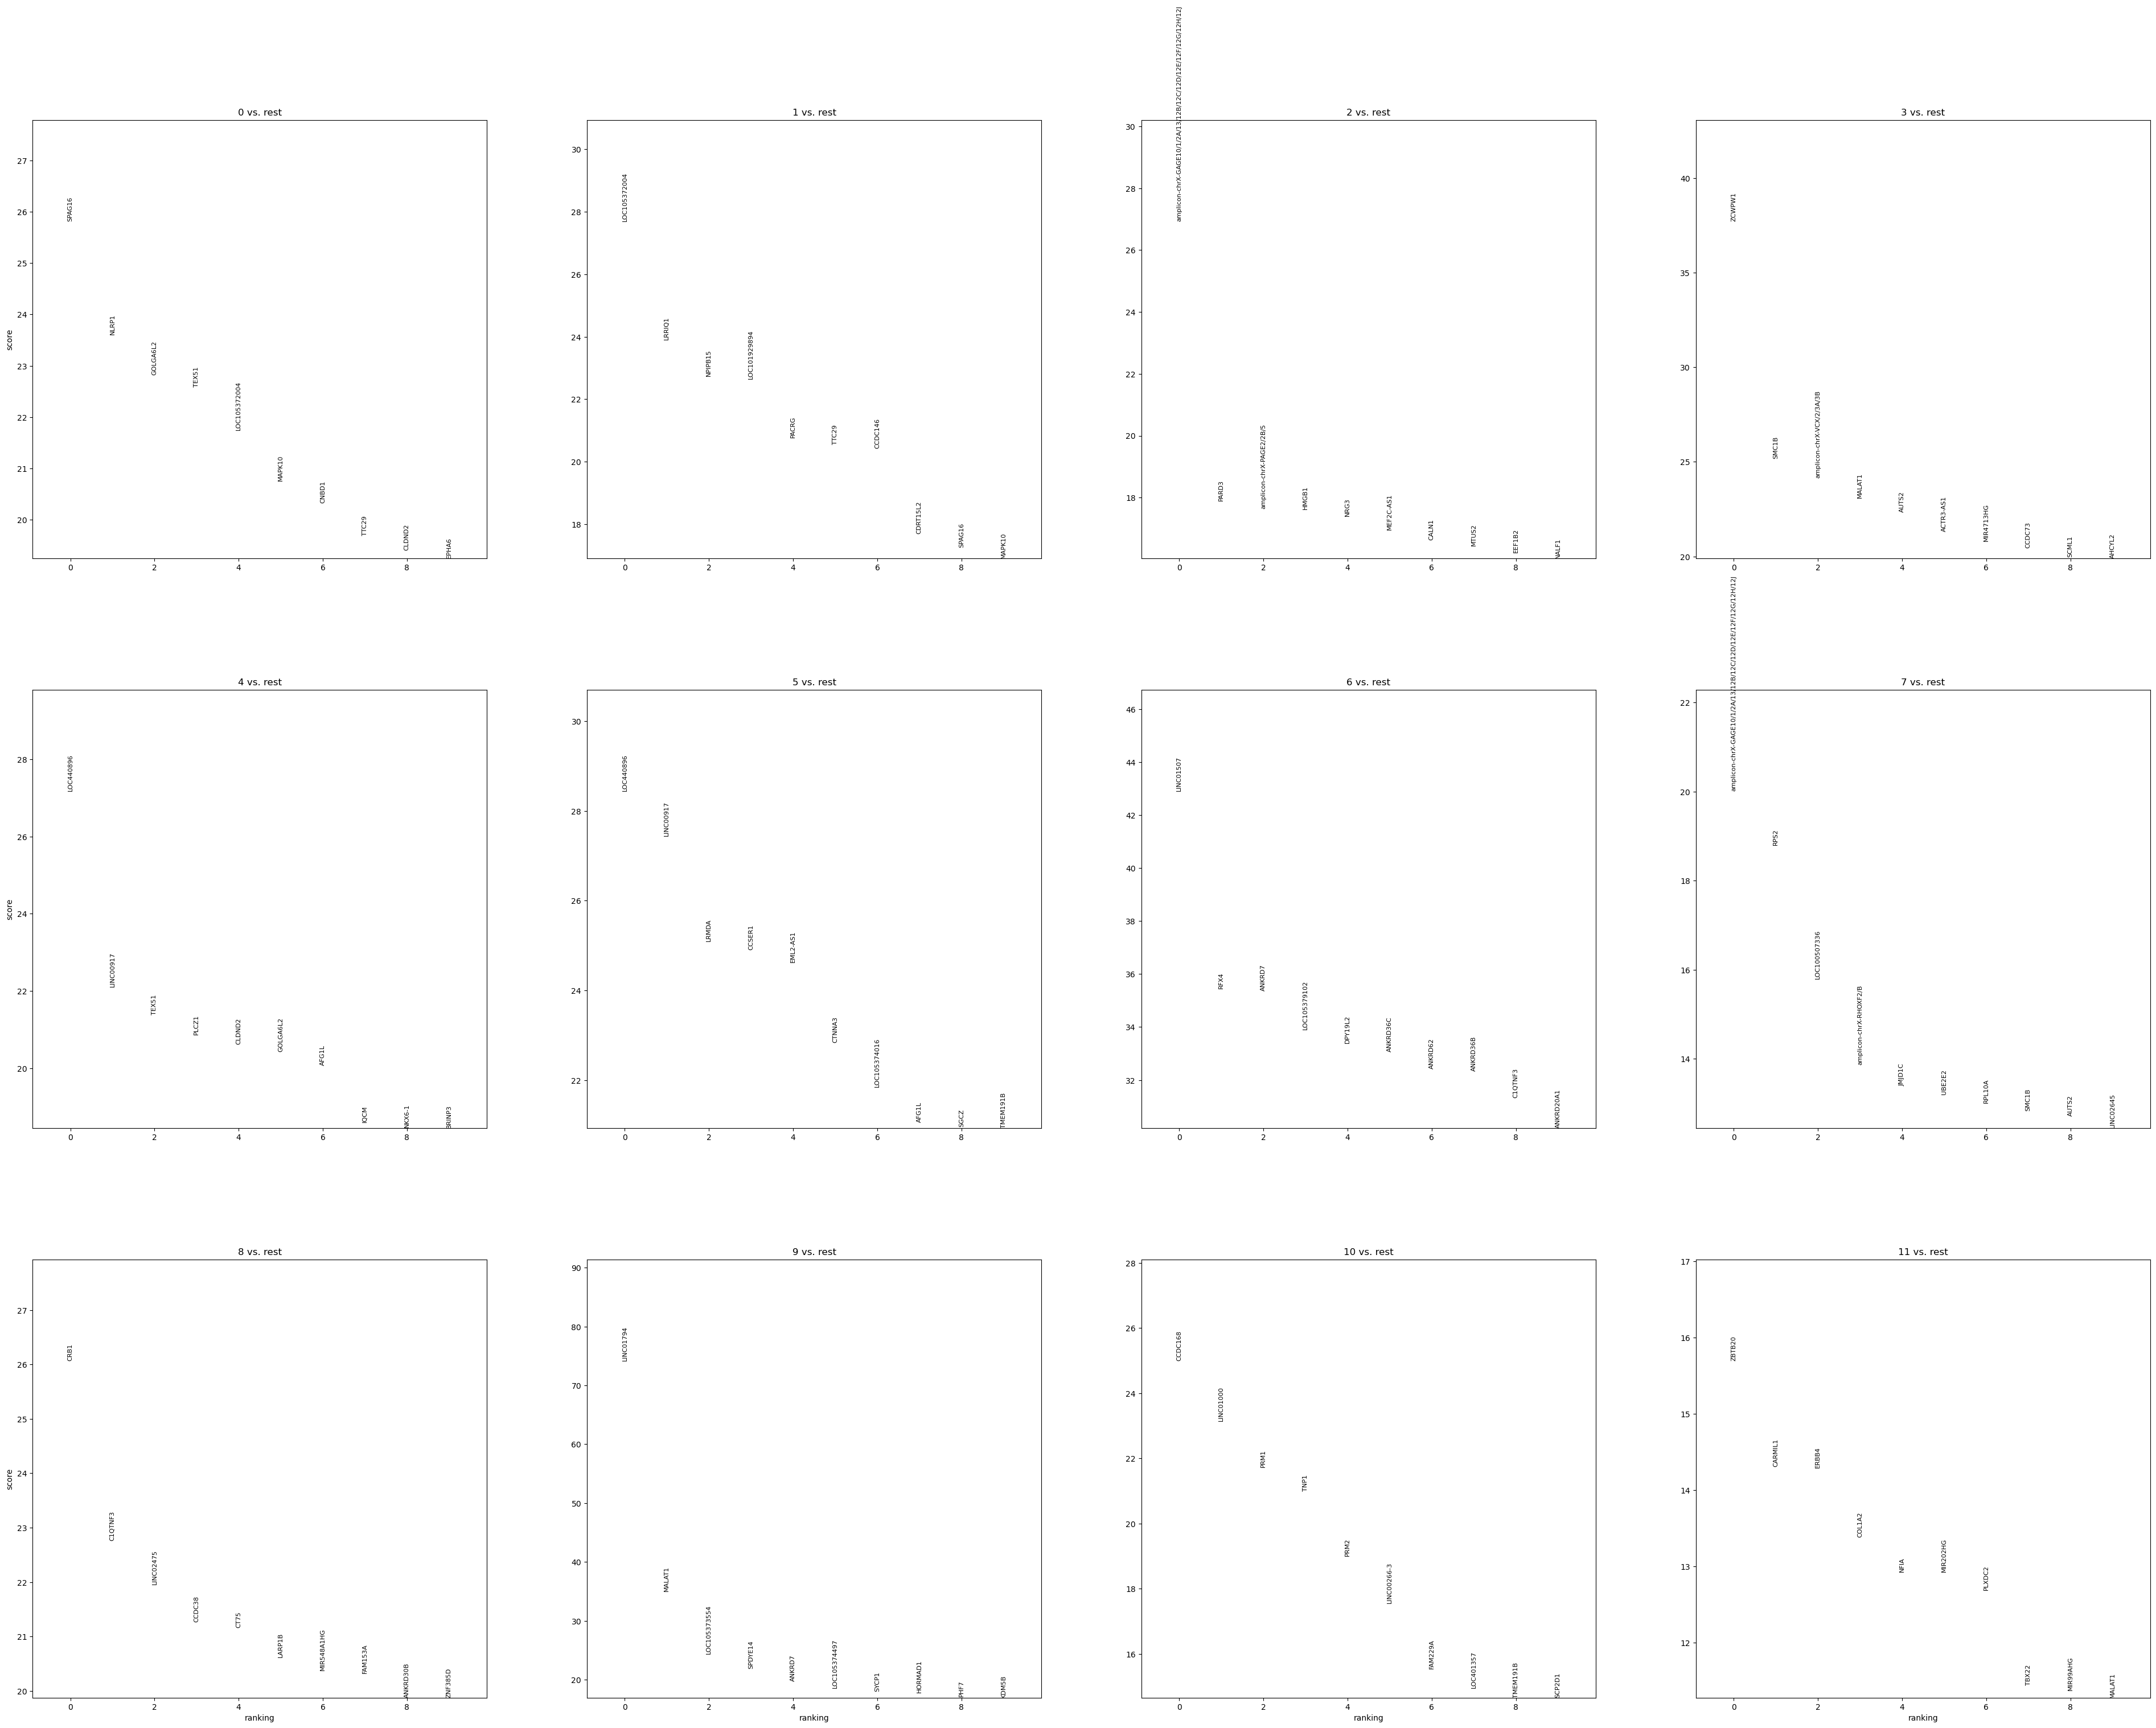

In [49]:
sc.pl.rank_genes_groups(adata, n_genes=10, groupby='leiden_R.3', key='DE_leiden', sharey=False) # sharey=False to change y axis to individual score

In [50]:
adata

AnnData object with n_obs × n_vars = 5043 × 25535
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets', 'SpermatogoniaA_score', 'SpermatogoniaB_score', 'SpermatocytesI_score', 'SpermatocytesII_score', 'Round.Spt_score', 'Elong.Spt_score', 'Sertoli_score', 'Macroph_score', 'Leydig_score', 'Endothelial_score', 'Undif. SG_score', 'Dif. SG_score', 'Lept. SC_score', 'Zyg. SC_score', 'Pach.Dipl. SC_score', 'Early round SD_score', 'Late round SD_score', 'Elong SD_score', 'SC_score', 'SC.I_score', 'SC.II_score', 'leiden_R.3', 'leiden_R.2', 'leiden_R.1', 'spermatogenesis_types'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DATASET_colors', 'hvg', 'leiden', 'leiden_R.1_colors', 'leiden_R.2_colors', 'leiden_R.3_colors', 'neighbors', 'pca', 'umap', 'DE_leiden', 'spermatogenesis_types_colors'


Organize result in a table. Each column has the cluster numbers with _N, _P representing respectively the gene Names and their P-values

In [51]:
result = adata.uns['DE_leiden']
groups = result['names'].dtype.names
X = pd.DataFrame(
    {group + '_' + key[:1].upper(): result[key][group]
    for group in groups for key in ['names', 'pvals_adj']})
X.head() #print only first five lines

0_N           0_P           1_N            1_P  \
0        SPAG16  1.828284e-97  LOC105372004  4.221549e-104   
1         NLRP1  1.005131e-84        LRRIQ1   5.503471e-85   
2      GOLGA6L2  2.087500e-81       NPIPB15   5.843420e-79   
3         TEX51  1.145518e-79  LOC101929894   4.217951e-78   
4  LOC105372004  5.630407e-76         PACRG   1.265881e-68   

                                                 2_N            2_P  \
0  amplicon-chrX-GAGE10/1/2A/13/12B/12C/12D/12E/1...  6.923762e-101   
1                                              PARD3   5.412905e-55   
2                           amplicon-chrX-PAGE2/2B/5   1.385534e-53   
3                                              HMGB1   4.958348e-54   
4                                               NRG3   2.335711e-52   

                         3_N            3_P        4_N            4_P  ...  \
0                     ZCWPW1  8.151856e-149  LOC440896  4.026893e-104  ...   
1                      SMC1B   7.007829e-91  LINC00917   1.255902e-76  ...   
2  amplicon-chrX-VCX/2/3A/3B   1.571621e-85      TEX51   2.055385e-72  ...   
3                     MALAT1   2.610773e-85      PLCZ1   3.383387e-69  ...   
4                      AUTS2   4.071935e-77     CLDND2   1.829777e-68  ...   

                                                 7_N           7_P        8_N  \
0  amplicon-chrX-GAGE10/1/2A/13/12B/12C/12D/12E/1...  1.767409e-62       CRB1   
1                                               RPS2  2.723269e-56    C1QTNF3   
2                                       LOC100507336  5.048851e-43  LINC02475   
3                             amplicon-chrX-RHOXF2/B  6.909499e-35     CCDC38   
4                                             JMJD1C  3.081456e-33       CT75   

            8_P           9_N            9_P       10_N          10_P  \
0  2.152225e-85     LINC01794  2.569789e-200    CCDC168  2.703873e-58   
1  3.401119e-73        MALAT1  1.829135e-109  LINC01000  8.092992e-54   
2  1.051164e-67  LOC105373554   2.522447e-73       PRM1  3.873762e-50   
3  2.472344e-65       SPDYE14   3.316095e-63       TNP1  2.739905e-48   
4  1.133553e-64        ANKRD7   6.606983e-56       PRM2  5.984493e-43   

      11_N          11_P  
0   ZBTB20  2.088150e-27  
1  CARMIL1  1.244014e-24  
2    ERBB4  1.363859e-24  
3   COL1A2  9.505147e-23  
4     NFIA  7.471611e-22  

[5 rows x 24 columns]

In [53]:
adata.layers['norm_sct']

array([[-0.38624061, -0.0533433 , -0.11852944, ..., -0.17378488,
        -0.08765947, -0.32689791],
       [ 3.37791163, -0.04600964, -0.10156935, ..., -0.13910251,
        -0.074139  , -0.28549243],
       [-0.52358889, -0.07991128, -0.18076913, ..., -0.30137505,
        -0.13673458, -0.47723768],
       ...,
       [-0.22962205, -0.07757154, -0.16150276, ..., -0.38675177,
        -0.14854633, -0.40094363],
       [-0.369877  , -0.10472299, -0.22516694, ..., -0.51716447,
        -0.19869875, -0.55431673],
       [-0.31920056, -0.09486361, -0.20196574, ..., -0.46983733,
        -0.18049131, -0.49915436]])

In [52]:
X[ ['3_N'] ]


3_N
0                                             ZCWPW1
1                                              SMC1B
2                          amplicon-chrX-VCX/2/3A/3B
3                                             MALAT1
4                                              AUTS2
5                                          ACTR3-AS1
6                                          MIR4713HG
7                                             CCDC73
8                                              SCML1
9                                             AHCYL2
10                                             STAG1
11                                           PPP1R42
12                                          RAD51AP2
13                                         TNFAIP8L3
14                                            DMRTC2
15                                              DPH7
16                                         LINC01572
17                                             SPDYA
18                                              MEI1
19                                      LOC105374308
20                                         LINC02645
21                                           STXBP5L
22                                      LOC100507412
23                                             ABCA5
24                                             SYCP3
25                                             RIMS2
26                                             HELLS
27                                             TAF15
28  amplicon-chrX-CT47A1/2/3/4/5/6/7/8/9/10/11/12/B1
29                                             PCBP3
30                                              DMC1
31                                             NFAT5
32                                              SDK1
33                                             CLSPN
34                                              TTC3
35                                              EYA3
36                                        ZBTB46-AS1
37                                            STRIP2
38                                            ERICH1
39                                             EPB41
40                                           HORMAD1
41                                             AP4E1
42                                             KCNQ1
43                                             TEX15
44                                           GPATCH8
45                                          KCNQ1OT1
46                                              PTK2
47                                             RAD9B
48                                          C18orf63
49                                             CENPP

In [54]:
pd.DataFrame(adata.uns['DE_leiden']['names']).head() # top 5 ranked genes for each cluster

0             1  \
0        SPAG16  LOC105372004   
1         NLRP1        LRRIQ1   
2      GOLGA6L2       NPIPB15   
3         TEX51  LOC101929894   
4  LOC105372004         PACRG   

                                                   2  \
0  amplicon-chrX-GAGE10/1/2A/13/12B/12C/12D/12E/1...   
1                                              PARD3   
2                           amplicon-chrX-PAGE2/2B/5   
3                                              HMGB1   
4                                               NRG3   

                           3          4          5             6  \
0                     ZCWPW1  LOC440896  LOC440896     LINC01507   
1                      SMC1B  LINC00917  LINC00917          RFX4   
2  amplicon-chrX-VCX/2/3A/3B      TEX51      LRMDA        ANKRD7   
3                     MALAT1      PLCZ1     CCSER1  LOC105379102   
4                      AUTS2     CLDND2   EML2-AS1       DPY19L2   

                                                   7          8             9  \
0  amplicon-chrX-GAGE10/1/2A/13/12B/12C/12D/12E/1...       CRB1     LINC01794   
1                                               RPS2    C1QTNF3        MALAT1   
2                                       LOC100507336  LINC02475  LOC105373554   
3                             amplicon-chrX-RHOXF2/B     CCDC38       SPDYE14   
4                                             JMJD1C       CT75        ANKRD7   

          10       11  
0    CCDC168   ZBTB20  
1  LINC01000  CARMIL1  
2       PRM1    ERBB4  
3       TNP1   COL1A2  
4       PRM2     NFIA

In [55]:
cd /home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/results

/faststorage/project/testis_singlecell/Workspaces/adahl/birc-project-akd/results


In [56]:
!mkdir -p cluster_results/BON

In [57]:
X.to_csv('cluster_results/BON/expr_annotation.csv', sep=',', index=None)

In [36]:
# cell type names for the chosen clusters

#new_names = {
#    '0':'SpermatogoniaA.1',
#    '1':'SpermatogoniaA.2',
#    '2':'Myoid',
#    '3':'Endothelial',
#    '4':'Leydig',
#    '5':'SpermatogoniaB',
#    '6':'Elong_Spermatids',
#    '7':'SpermatocitesII.1',
#    '8':'SpermatocitesII.2',
#    '9':'Round_Spermatids',
#    '10':'SpermatocitesI',
#    '11':'Macroph',
#    '12':'Pericytes'}


new_names = {
    '0':'Early round SD',
    '1':'Early round SD',
    '2':'Undif. SG',
    '3':'SC.I',
    '4':'Late round SD',
    '5':'Late round SD',
    '6':'SC.II',
    '7':'Dif. SG',
    '8':'SC.II',
    '9':'SC.I',
    '10':'Elong SD',
    '11':'Sertoli'
}


We merge the clusters with same names. This cannot be done with a categorical object, where categories cannot have the same name. We convert the cluster names into a simple array to do this, and then reconvert it to a categorical object.

In [37]:
adata.obs['spermatogenesis_types'] = [new_names[x] for x in adata.obs['leiden_R.3'].tolist()]

In [38]:
palette_dict = {"Undif. SG":'lightblue',"Dif. SG":'blue',"SC.I":'lightgreen','SC.II':'green','Early round SD':'yellow','Late round SD':'orange','Elong SD':'red','Sertoli':'pink'}

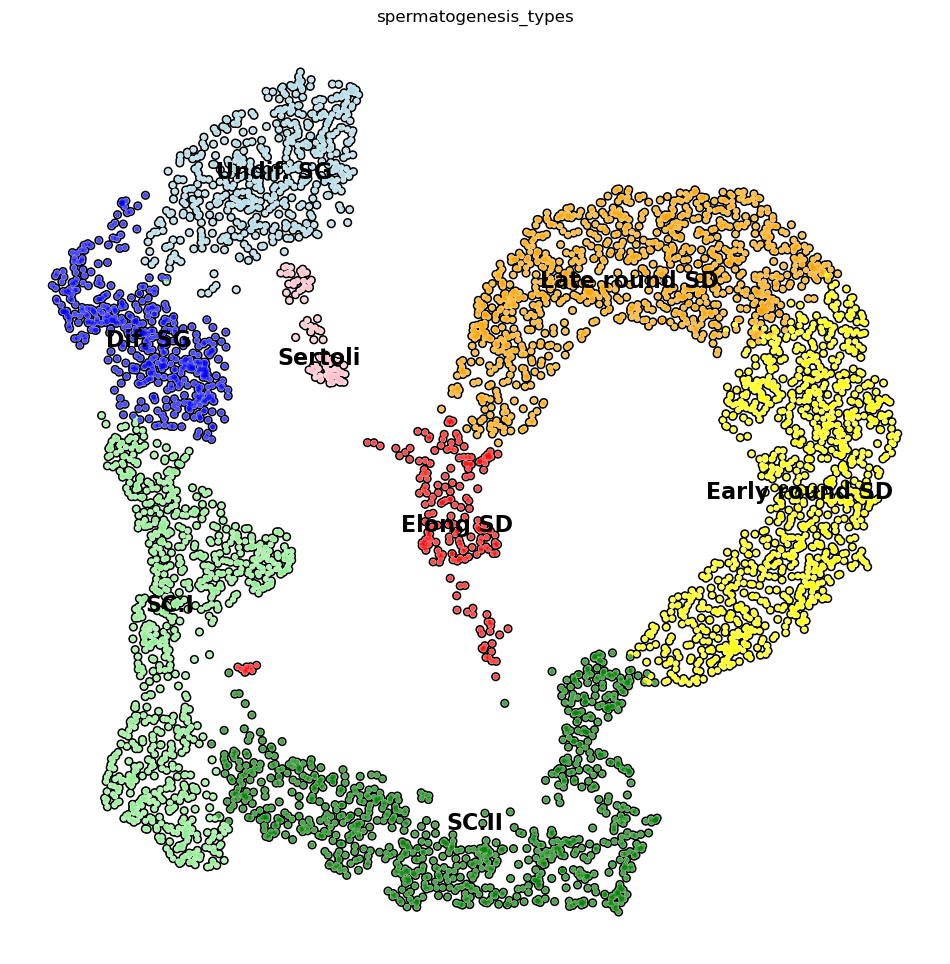

In [39]:
plt.rcParams['figure.figsize'] = (12,12)
sc.pl.umap( adata, color=['spermatogenesis_types'],
           palette=palette_dict,
           legend_loc='on data', 
           legend_fontsize=16,
           frameon=False,
           size=60,
           add_outline=True,
           ncols=1  
           )

In [3]:
saved_adata = '/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/results/cluster_results/BON/cluster_adata.h5ad'
adata = sc.read(saved_adata)

In [21]:
sc.tl.rank_genes_groups(adata, groupby='spermatogenesis_types', n_genes=50, key_added='DE_leiden_celltype') # diff.expressed genes in each cluster (t-test)

ranking genes
    finished: added to `.uns['DE_leiden_celltype']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


In [22]:
adata.obs['spermatogenesis_types']

SN219_AAACCTGAGAAAGTGG             SC.I
SN219_AAACCTGAGGCGCTCT          Dif. SG
SN219_AAACCTGAGTCGCCGT        Undif. SG
SN219_AAACCTGCAGCGTTCG    Late round SD
SN219_AAACCTGGTAAGAGAG             SC.I
                              ...      
SN224_TTTGTCAAGGGATCTG        Undif. SG
SN224_TTTGTCAAGTGAACGC            SC.II
SN224_TTTGTCACAGTAGAGC         Elong SD
SN224_TTTGTCACATCCTTGC            SC.II
SN224_TTTGTCATCCGCAGTG        Undif. SG
Name: spermatogenesis_types, Length: 5043, dtype: category
Categories (8, object): ['Dif. SG', 'Early round SD', 'Elong SD', 'Late round SD', 'SC.I', 'SC.II', 'Sertoli', 'Undif. SG']

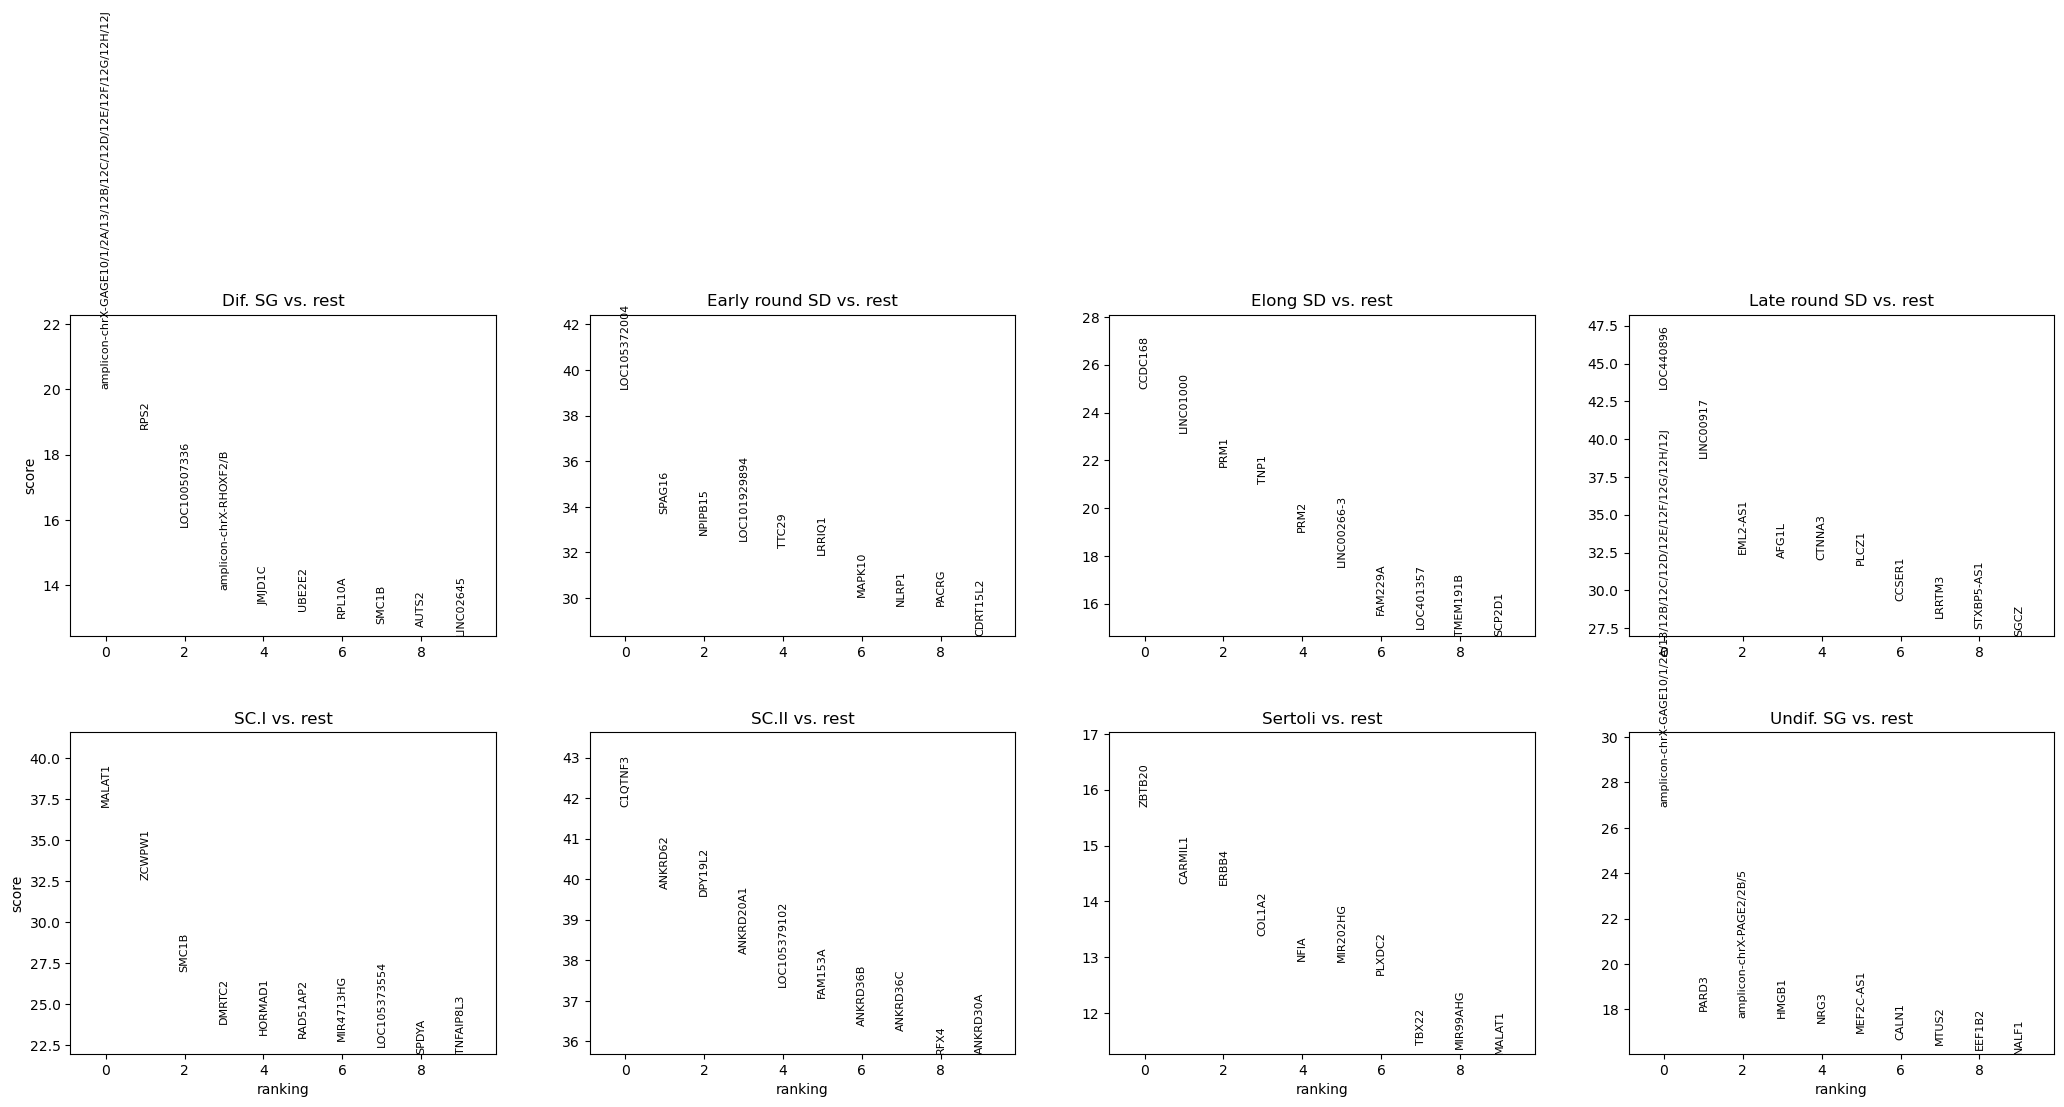

In [23]:
sc.pl.rank_genes_groups(adata, n_genes=10, groupby='spermatogenesis_types', key='DE_leiden_celltype', sharey=False) # sharey=False to change y axis to individual score

In [12]:
adata

AnnData object with n_obs × n_vars = 5043 × 25535
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets', 'SpermatogoniaA_score', 'SpermatogoniaB_score', 'SpermatocytesI_score', 'SpermatocytesII_score', 'Round.Spt_score', 'Elong.Spt_score', 'Sertoli_score', 'Macroph_score', 'Leydig_score', 'Endothelial_score', 'Undif. SG_score', 'Dif. SG_score', 'Lept. SC_score', 'Zyg. SC_score', 'Pach.Dipl. SC_score', 'Early round SD_score', 'Late round SD_score', 'Elong SD_score', 'SC_score', 'SC.I_score', 'SC.II_score', 'leiden_R.3', 'leiden_R.2', 'leiden_R.1', 'spermatogenesis_types'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DATASET_colors', 'DE_leiden', 'hvg', 'leiden', 'leiden_R.1_colors', 'leiden_R.2_colors', 'leiden_R.3_colors', 'neighbors', 'pca', 'spermatogenesis_types_colors', 'umap',

In [13]:
adata.uns['DE_leiden_celltype']['names'].dtype.names

('Dif. SG',
 'Early round SD',
 'Elong SD',
 'Late round SD',
 'SC.I',
 'SC.II',
 'Sertoli',
 'Undif. SG')

In [24]:
result2 = adata.uns['DE_leiden_celltype']
groups2 = result2['names'].dtype.names
X2 = pd.DataFrame(
    {group + '_' + key[:1].upper(): result2[key][group]
    for group in groups2 for key in ['names', 'pvals_adj']})
X2.head() #print only first five lines

Dif. SG_N     Dif. SG_P  \
0  amplicon-chrX-GAGE10/1/2A/13/12B/12C/12D/12E/1...  1.767409e-62   
1                                               RPS2  2.723269e-56   
2                                       LOC100507336  5.048851e-43   
3                             amplicon-chrX-RHOXF2/B  6.909499e-35   
4                                             JMJD1C  3.081456e-33   

  Early round SD_N  Early round SD_P Elong SD_N    Elong SD_P Late round SD_N  \
0     LOC105372004     2.877975e-214    CCDC168  2.703873e-58       LOC440896   
1           SPAG16     8.969243e-177  LINC01000  8.092992e-54       LINC00917   
2          NPIPB15     7.909498e-169       PRM1  3.873762e-50        EML2-AS1   
3     LOC101929894     2.666285e-165       TNP1  2.739905e-48           AFG1L   
4            TTC29     3.754971e-161       PRM2  5.984493e-43          CTNNA3   

   Late round SD_P   SC.I_N         SC.I_P       SC.II_N        SC.II_P  \
0    5.490599e-251   MALAT1  3.057214e-180       C1QTNF3  1.216373e-218   
1    2.032980e-203   ZCWPW1  1.361111e-148       ANKRD62  1.967267e-201   
2    1.775091e-157    SMC1B  6.405510e-116       DPY19L2  1.242421e-200   
3    1.758414e-162   DMRTC2   3.861009e-94     ANKRD20A1  1.355095e-187   
4    1.905086e-159  HORMAD1   1.736418e-91  LOC105379102  1.258779e-182   

  Sertoli_N     Sertoli_P                                        Undif. SG_N  \
0    ZBTB20  2.088150e-27  amplicon-chrX-GAGE10/1/2A/13/12B/12C/12D/12E/1...   
1   CARMIL1  1.244014e-24                                              PARD3   
2     ERBB4  1.363859e-24                           amplicon-chrX-PAGE2/2B/5   
3    COL1A2  9.505147e-23                                              HMGB1   
4      NFIA  7.471611e-22                                               NRG3   

     Undif. SG_P  
0  6.923762e-101  
1   5.412905e-55  
2   1.385534e-53  
3   4.958348e-54  
4   2.335711e-52

In [25]:
cd /home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/results

/faststorage/project/testis_singlecell/Workspaces/adahl/birc-project-akd/results


In [26]:
X2.to_csv('cluster_results/BON/expr_annotation_celltype.csv', sep=',', index=None)

In [27]:
path_out = f'/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/results/cluster_results/BON'

if not os.path.exists(path_out):
    os.makedirs(path_out)

adata_out = f'{path_out}/cluster_adata.h5ad'

In [28]:
adata.write(adata_out)

In [11]:
adata

AnnData object with n_obs × n_vars = 5043 × 25535
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets', 'Round.Spt_score', 'Elong.Spt_score', 'Sertoli_score', 'Macroph_score', 'Leydig_score', 'Endothelial_score', 'Undif. SG_score', 'Dif. SG_score', 'Lept. SC_score', 'Zyg. SC_score', 'Pach.Dipl. SC_score', 'Early round SD_score', 'Late round SD_score', 'Elong SD_score', 'SC_score', 'SC.I_score', 'SC.II_score', 'leiden_R.3', 'leiden_R.2', 'leiden_R.1', 'spermatogenesis_types'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DATASET_colors', 'DE_leiden', 'DE_leiden_celltype', 'hvg', 'leiden', 'leiden_R.1_colors', 'leiden_R.2_colors', 'leiden_R.3_colors', 'neighbors', 'pca', 'spermatogenesis_types_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'norm_sct', 'raw_co

In [13]:
del(adata.obs['Elong.Spt_score'])


In [ ]:
del(adata.obs['Zyg. SC_score'])

In [ ]:
del(adata.obs['Elong.Spt_score'])

In [ ]:
del(adata.obs['Elong.Spt_score'])

In [ ]:
del(adata.obs['Elong.Spt_score'])

In [ ]:
del(adata.obs['Elong.Spt_score'])

In [ ]:
del(adata.obs['Elong.Spt_score'])